In [30]:
import numpy as np




## Defining the generic metrics class

In [31]:
pwd


'/Users/peterle/Desktop/Integrify Materials/ML_for_python/ml_for_python_2019/3_optimization_gd_pytorch'

In [13]:
class GeneralModelClass:
    # Where k∗ is the numbers of parameters you're estimating INCLUDING an intercept. 
    #(The residual vector will exist in an n−k∗ dimensional linear space.)

    # If you include an intercept term in a regression and k refers to the number of regressors
    # not including the intercept then k∗=k+1.
         
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.predict(self.data)) ** 2
        self.sq_error_ = np.sum(squared_errors)
        return self.sq_error_
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        self.sst_ = np.sum(squared_errors)
        return self.sst_
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        self.r_sq_ = 1 - self.sse()/self.sst()
        return self.r_sq_
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        self.adj_r_sq_ = 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)
        return self.adj_r_sq_
    
    def rmse(self):
        '''returns calculated value of mse'''
        # using predict, data and target, find the RMSE error
        self.rmse_ =np.sqrt( np.mean( (self.predict(self.data) - self.target) ** 2 ))
        return self.rmse_
    
    def pretty_print_stats(self):
        '''returns report of statistics for a given model object'''
        items = ( ('rmse:', self.rmse()), ('r^2:', self.r_squared()), 
                  ('adj_r^2:', self.adj_r_squared()))
        for item in items:
            print('{0:8} {1:.4f}'.format(item[0], item[1]))


## Defining the Linear Regression Class

In [14]:
# only makes sense for Linear Regression https://stats.stackexchange.com/questions/23128/solving-for-regression-parameters-in-closed-form-vs-gradient-descent
class LinearRegression_(GeneralModelClass):
    
    
    def __init__(self, fit_intercept=True):
        self.coef_ = None
        self.intercept_ = None
        self._fit_intercept = fit_intercept
          
        
    def fit(self, X, y):
        """
        Fit model coefficients.

        Arguments:
        X: 1D or 2D numpy array 
        y: 1D numpy array
        """
         #degrees of freedom population dep. variable variance -- this is total amount of degrees
        self._dft = X.shape[0] - 1   
        # degrees of freedom for the residuals
        self._dfe = X.shape[0] - X.shape[1] - 1  # the more independent variables, the less adj_R-sq
        
        # training data & ground truth data
        self.data = X
        self.target = y
                
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
            
        # add bias if fit_intercept
        if self._fit_intercept:
            X = np.c_[np.ones(X.shape[0]),X]
        
        # closed form solution
        xTx =np.dot(X.T, X) # using X transposed and X matrices, find the data covariance matrix (X.T ?operator? X)
        inverse_xTx = np.linalg.inv(xTx) # find the inverse of the cov matrix, i.e. the precision matrix
        xTy = np.dot(X.T, y) # find X.transposed times y using ?what? operator
        coef = np.dot(inverse_xTx, xTy)
        
        # set attributes
        if self._fit_intercept:
            self.intercept_ = coef[0]
            self.coef_ = coef[1:]# the remaining coefficients go here
        else:
            self.intercept_ = 0 # otherwise set intercept to be 0
            self.coef_ = coef
            
    def predict(self, X):
        """Output model prediction.

        Arguments:
        X: 1D or 2D numpy array 
        """
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)  # force 1D array into a column vector
        return self.intercept_ + np.dot(X, self.coef_)#using intercept, coefficients and X and linear regression formula, find the predictions
    
    def __str__(self):
        return "Results: b: {}, m: {}, Final Total error: {}".format(round(self.b, 2), round(self.m, 2), round(self.compute_error(), 2))

In [15]:
lr = LinearRegression_()
#lr.fit(X_data, y_target)
intercept = lr.intercept_
parameters = lr.coef_
#predictions = lr.predict(X_new_data)

## The Problem : Housing Price Prediction

In [16]:
!pip install numpy --upgrade --user # to make sure your numpy version is updated

Requirement already up-to-date: numpy in /Users/peterle/.local/lib/python3.7/site-packages (1.17.0)
You should consider upgrading via the 'pip install --upgrade pip' command.


### Loading the Dataset

In [21]:
from sklearn.datasets import load_boston
import pandas as pd
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Understanding the Data using Metadata

In [22]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [16]:
# find the sum of null values for each variable

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Visualizing  The Dependent Variable

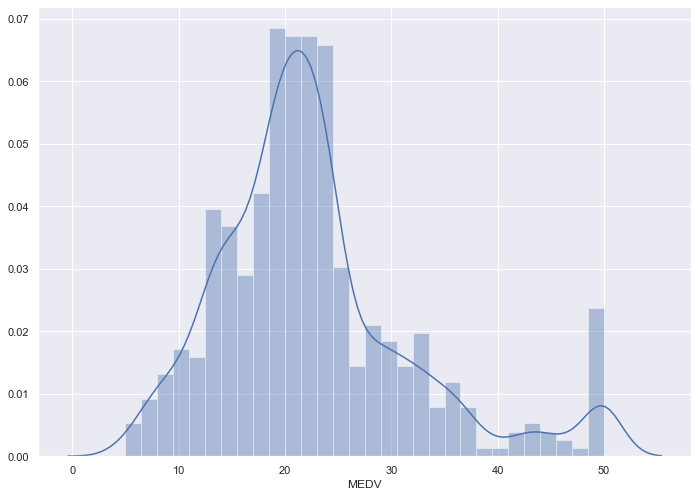

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
# visualize the distribution of the dependent variable (KDE + 30-bin histogram)
sns.distplot(boston['MEDV'], kde=True, bins=30)

### Visualizing Pairwise Relationships

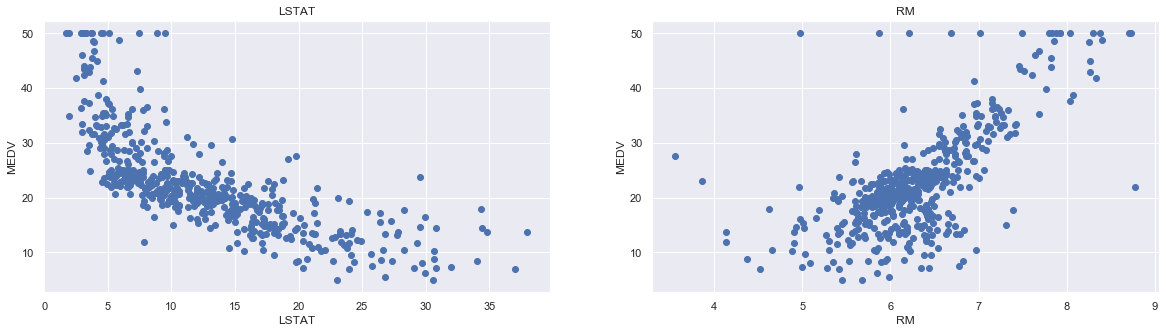

In [26]:
plt.figure(figsize=(20, 5))

# choose your own custom features here and make subplots to visualize pairwise relationships
# alternatively, you may use the pairplot
features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [27]:
x_vars = boston.columns.difference(['MEDV'])
y_vars = ['MEDV']
print(boston.columns)
print(x_vars)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')
Index(['AGE', 'B', 'CHAS', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO',
       'RAD', 'RM', 'TAX', 'ZN'],
      dtype='object')


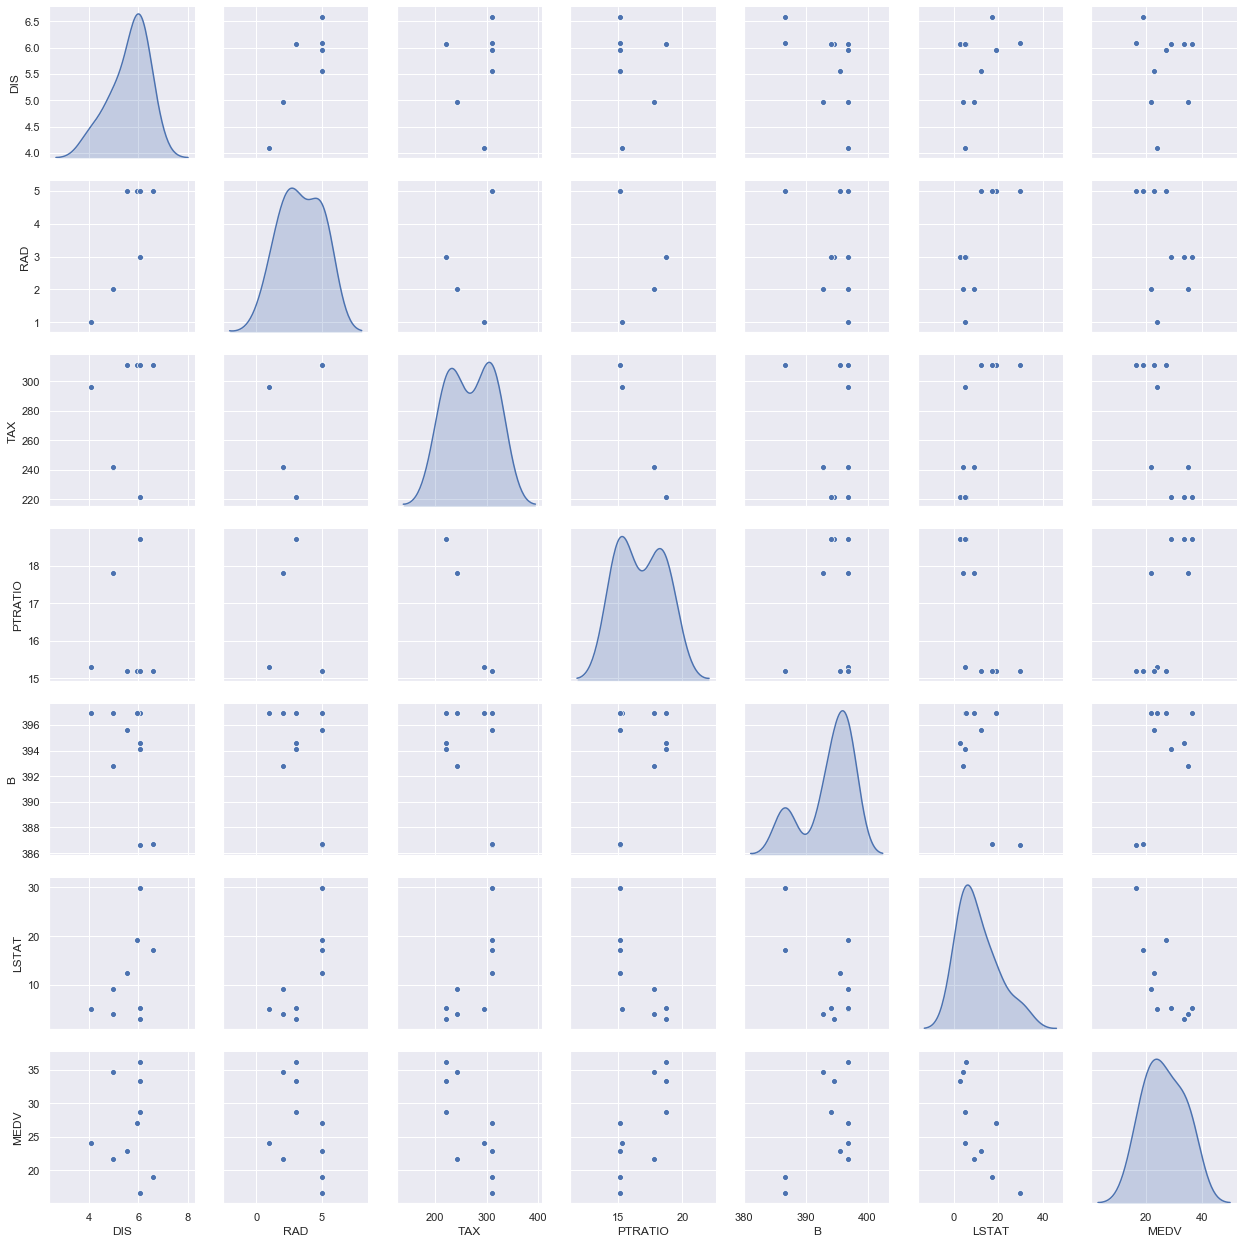

In [28]:
import seaborn as sns
#sns.pairplot(data=boston.iloc[0:10,:],x_vars=x_vars,y_vars=y_vars, hue = "RAD")
sns.pairplot(data=boston.iloc[0:10,:],vars = boston.columns[-7:],diag_kind="kde")
#sns.pairplot(data=boston.iloc[0:10,:]) runs very slowly

## Modeling

### Selecting Features Based on Correlation

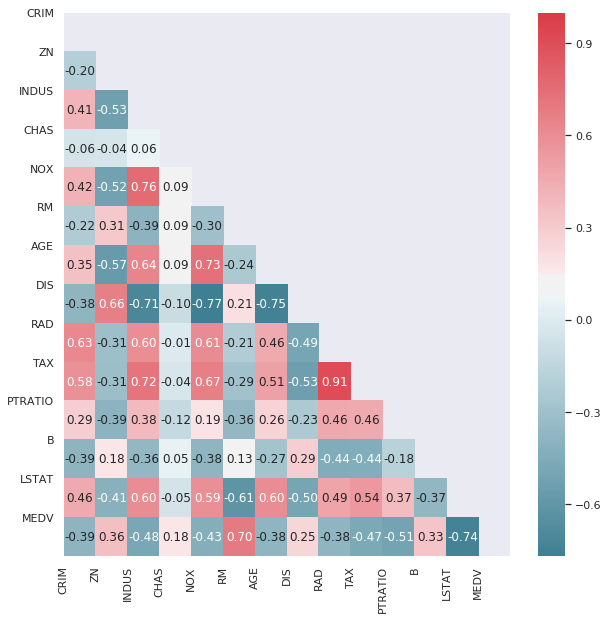

In [18]:
def doCorrelationReduction(corr_matrix = boston.corr(), original_data = boston, corr_thr=0.7):
    """Method to  select only the data with features that have low correlations between themselves"""
    import numpy as np
    corr_matrix_abs = corr_matrix.abs()
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))  # # Select upper triangle of correlation matrix
    # # Find index of feature columns with correlation greater than threshold
    to_drop = 
    # [inside the list, using upper.columns, select any column (name) that has higher correlation than corr_thr value]
    low_cor_data = 
    # using the difference operator on the original data dataframe columns, subtract the to_drop columns

    return low_cor_data

def heatMap(df, mirror=False):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(10, 10))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show(
    
heatMap(df=boston)
boston_corr_reduced = doCorrelationReduction()

### Notice Any Dimensionality Reduction?

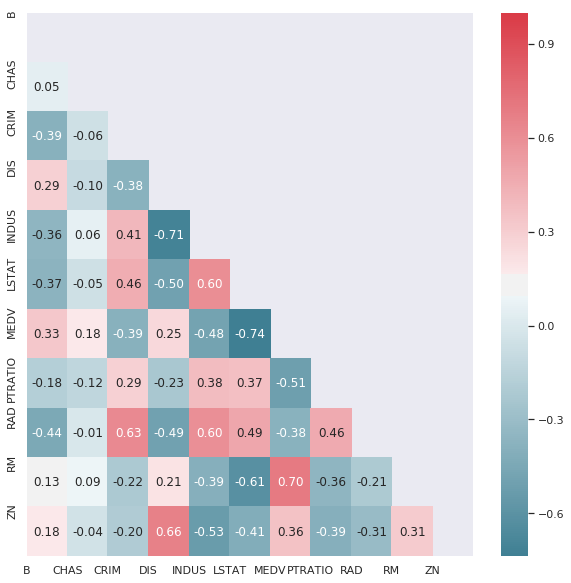

In [19]:
heatMap(df=boston_corr_reduced)

### Splitting Data for Measuring Generalization Error

In [3]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

NameError: name 'pd' is not defined

### Linear Regression Using Your Own OOP Implementation

In [9]:
# importlib.reload(mymodule), # https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
general_model = GeneralModelClass()
linreg_model = LinearRegression_(general_model)
linreg_model.__dict__
linreg_model.fit(X=X_train,y=Y_train)
linreg_model.pretty_print_stats()

NameError: name 'LinearRegression_' is not defined

In [ ]:
import inspect
lines = inspect.getsource(linreg_model.pretty_print_stats)
print(lines)



**make sure if you add features that you transform both train and test when you transform your data**


### Linear Regression Using Statsmodels

You can implement linear regression in Python relatively easily by using the package statsmodels as well. Typically, this is desirable when there is a need for more detailed results.

In [27]:
import statsmodels.api as sm
X_constant_added = sm.add_constant(x=X)
model = sm.OLS(y, x=X_constant_added)
results_statsmodel = model.fit()
print(results.summary())
print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params)

/home/alaridl/anaconda3/envs/python_for_ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


AttributeError: 'NoneType' object has no attribute 'shape'

## Task : Multiple Regression Comparison with Different Libraries


In this task, your task is to predict the Median value of owner-occupied homes in $1000's in Boston, using multiple different features.

**Before you start : Split the Boston housing dataset into training and test sets using Scikit-learn train-test split function.**

Starting Question : 
**Compare the Implementation of the matrix transformations in the `fit`-method of the Linear Regression implementation to the tasks in the last assignments. What do you notice? What is the closed form solution called in other words? We talked about this on Monday.**

- 0.0 Are the features linearly independent of each other? Show this programmatically.
- 0.1 Are the assumptions for linear regression fulfilled?

[assumptions](https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0)


In the next steps, we will look at some concrete models. **Remember to measure both the training and prediction times of your runs.**

0.0 Referring to the maximum likelihood notebook, implement a method to compute the negative log-likelihood.

- 1.0 Define **optimize (train)** a multiple linear regression model in Scikit-Learn with all features
- 1.1 Define **optimize (train)** a multiple linear regression model in Scikit-Learn with low correlated features

[Scikit Lin Reg](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

**What fitting methods are available here?**


- 3.0 Define and **optimize (train)** a multiple linear regression model in statsmodels with all features
- 3.1  Define and **optimize (train)** a multiple linear regression model in statsmodels with low correlated features

[Statsmodels Lin Reg](https://www.statsmodels.org/stable/regression.html)

"This module allows estimation by ordinary least squares (OLS), weighted least squares (WLS), generalized least squares (GLS), and feasible generalized least squares with autocorrelated AR(p) errors."

- Which library (statsmodels or Scikit-learn) allows for more flexible fitting procedure?


- 5. Remember that the training error is not a good metric for evaluation how well a model generalizes. That's why you should now compare the results by MSE achieved on the test set. 


- Which model generalizes the best? Plot the MSE VS neg-log-likelihood for each of the models. Why does the graph look like it does?
- Did you see any significant improvement in generalization by eliminating features that are highly correlated to others?
- Was there any considerable speed differences between the runtimes of the model? Did you use GPU or not?



### BONUS POINT QUESTIONS (+1.5 %):

----------------------------------------------------------
- 2.0 Define and **optimize (train)** a multiple **polynomial** regression model in Scikit-Learn with all features
- 2.1 Define and **optimize (train)** a multiple **polynomial** regression model in Scikit-Learn with low correlated features

AND

- Use Bayesian Feature Selection (refer to the appropriate method in SkLearn or Lasso to Select the best performing features).

---------------------------------------------------------------------
AND

- 4.0 Define and **optimize (train)** a multiple linear regression model in Pytorch with all features
- 4.1 Define and **optimize (train)** a multiple linear regression model in Pytorch with low correlated features


**What needs to be included** :

Answers to the previously mentioned questions, but now comparing all the trained models between each other:

- Which model generalizes the best?  Plot the MSE VS neg-log-likelihood for each of the models. Why does the graph look like it does?
- Did you see any significant improvement in generalization by eliminating features that are highly correlated to others?
- Was there any considerable speed differences between the runtimes of the model? Did you use GPU or not?

In [ ]:
## predicted response
print('predicted response:', results.fittedvalues, sep='\n')
print('predicted response:', results.predict(x), sep='\n')


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

linreg_model_sklearn = LinearRegression().fit(x=X, y=Y)
transformer = PolynomialFeatures(degree=2, include_bias=False)
X_with_polynomial =  transformer.transform(x=X)



In [ ]:
## Comparison of Predictions
y_pred_own = linreg_model.predict(X=X_test)
y_pred_sklearn = linreg_model_sklearn.predict(x=X_test)


### Linear Independence / Dependence
[stats stackexchange reference](https://stats.stackexchange.com/questions/92522/linearly-dependent-features)


In [39]:
from numpy.linalg import matrix_rank
if matrix_rank(boston.values) == len(boston.columns):
    print("You have a full-rank data matrix, no linearly dependent features!")
else :
    print("Some features are linearly dependent!")


You have a full-rank data matrix, no linearly dependent features!
